## MLP Neural Net Model Version 2

- v2 focus is to use a dataset with less features, with the help of feature importance scores determined by XGBoost model.

- Loads Filtered Dataset
- Converts object types as numbers for embedding layers
- Splits Data, standarize numerical values
- Builds, Trains, Evaluates Model
- Plots training and validation metrics

In [172]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import random
import os

In [173]:
# Set seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [174]:
# Load encoded dataset - Use nfl_encoded_v2.csv
print('Loading CSV (this may take a while for large files)...')
nfl_filtered = pd.read_csv("../dataset/nfl_encoded_v2.csv", low_memory=False, index_col=0)

print(f"Dataset shape: {nfl_filtered.shape}")
print(f"\nData types:\n{nfl_filtered.dtypes}")

Loading CSV (this may take a while for large files)...
Dataset shape: (318668, 20)

Data types:
posteam                        object
defteam                        object
posteam_type                   object
yardline_100                  float64
qtr                             int64
down                            int64
ydstogo                         int64
goal_to_go                      int64
score_differential            float64
game_half                      object
drive                           int64
posteam_timeouts_remaining      int64
defteam_timeouts_remaining      int64
shotgun                         int64
no_huddle                       int64
quarter_seconds_remaining     float64
half_seconds_remaining        float64
game_seconds_remaining        float64
side_of_field                  object
play_type                       int64
dtype: object


In [175]:
# Remove features with low importance scores
nfl_filtered = nfl_filtered.drop(columns=['posteam_type', 'drive', 'no_huddle', 'quarter_seconds_remaining'])

In [176]:
# Add features to help with model training
# 1. Pressure situation: down * yards to go
nfl_filtered['down_ydstogo'] = nfl_filtered['down'] * nfl_filtered['ydstogo']

# 2. Score pressure normalized by time
nfl_filtered['score_pressure'] = nfl_filtered['score_differential'] / (nfl_filtered['game_seconds_remaining'] + 1)

# 3. Red zone indicator
nfl_filtered['red_zone'] = (nfl_filtered['yardline_100'] <= 20).astype(int)

# 4. Short yardage situation
nfl_filtered['short_yardage'] = ((nfl_filtered['down'] >= 3) & (nfl_filtered['ydstogo'] <= 3)).astype(int)

# 5. Under 2 minutes (time pressure)
nfl_filtered['under_2min'] = (nfl_filtered['game_seconds_remaining'] < 120).astype(int)

print(f"Dataset shape: {nfl_filtered.shape}")
print(f"\nData types:\n{nfl_filtered.dtypes}")


Dataset shape: (318668, 21)

Data types:
posteam                        object
defteam                        object
yardline_100                  float64
qtr                             int64
down                            int64
ydstogo                         int64
goal_to_go                      int64
score_differential            float64
game_half                      object
posteam_timeouts_remaining      int64
defteam_timeouts_remaining      int64
shotgun                         int64
half_seconds_remaining        float64
game_seconds_remaining        float64
side_of_field                  object
play_type                       int64
down_ydstogo                    int64
score_pressure                float64
red_zone                        int64
short_yardage                   int64
under_2min                      int64
dtype: object


In [177]:
# Display all unique values for posteam
print("\nUnique posteam values:")
print(nfl_filtered['side_of_field'].unique())

# Display all unique values for defteam
print("\nUnique defteam values:")
print(nfl_filtered['defteam'].unique())

# Display all unique values for side of field and game half
print("\nUnique side of field values:")
print(nfl_filtered['side_of_field'].unique())

print("\nUnique game half values:")
print(nfl_filtered['game_half'].unique())



Unique posteam values:
['PIT' 'TEN' 'MID' 'CLE' 'MIN' 'NO' 'DET' 'DAL' 'TB' 'HOU' 'NYJ' 'IND'
 'JAC' 'DEN' 'CIN' 'CAR' 'PHI' 'KC' 'BAL' 'ATL' 'MIA' 'ARI' 'SF' 'STL'
 'SEA' 'NYG' 'WAS' 'GB' 'CHI' 'BUF' 'NE' 'OAK' 'SD' 'LA' 'JAX' 'LAC']

Unique defteam values:
['TEN' 'PIT' 'MIN' 'CLE' 'DET' 'NO' 'TB' 'DAL' 'NYJ' 'HOU' 'JAC' 'IND'
 'CIN' 'DEN' 'PHI' 'CAR' 'BAL' 'KC' 'MIA' 'ATL' 'SF' 'ARI' 'STL' 'SEA'
 'WAS' 'NYG' 'CHI' 'GB' 'BUF' 'NE' 'SD' 'OAK' 'LA' 'JAX' 'LAC']

Unique side of field values:
['PIT' 'TEN' 'MID' 'CLE' 'MIN' 'NO' 'DET' 'DAL' 'TB' 'HOU' 'NYJ' 'IND'
 'JAC' 'DEN' 'CIN' 'CAR' 'PHI' 'KC' 'BAL' 'ATL' 'MIA' 'ARI' 'SF' 'STL'
 'SEA' 'NYG' 'WAS' 'GB' 'CHI' 'BUF' 'NE' 'OAK' 'SD' 'LA' 'JAX' 'LAC']

Unique game half values:
['Half1' 'Half2' 'Overtime']


## Encode objects types as integers for embedding layers

In [178]:
# Get object type features
categorical_features = [col for col in nfl_filtered.columns if nfl_filtered[col].dtype == 'object']
print(f"Categorical features: {categorical_features}")

# Create label encoders for each categorical feature
label_encoders = {}
nfl_encoded = nfl_filtered.copy()

# Encode categorical features
for col in categorical_features:
    le = LabelEncoder()
    nfl_encoded[col] = le.fit_transform(nfl_encoded[col].astype(str))
    label_encoders[col] = le

    print(f"{col}: {len(le.classes_)} unique values")

Categorical features: ['posteam', 'defteam', 'game_half', 'side_of_field']
posteam: 35 unique values
defteam: 35 unique values
game_half: 3 unique values
side_of_field: 36 unique values


## Split Data

In [179]:
X = nfl_encoded.drop(columns=['play_type'])
y = nfl_encoded['play_type']

# Separate categorical and numerical features
categorical_cols = ["posteam", "defteam", "game_half", "side_of_field"]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")
print(f"Total features: {len(X.columns)}")

Categorical columns: ['posteam', 'defteam', 'game_half', 'side_of_field']
Numerical columns: ['yardline_100', 'qtr', 'down', 'ydstogo', 'goal_to_go', 'score_differential', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'shotgun', 'half_seconds_remaining', 'game_seconds_remaining', 'down_ydstogo', 'score_pressure', 'red_zone', 'short_yardage', 'under_2min']
Total features: 20


In [180]:
# Train-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Split again to get validation set
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create separate input layers for categorical and numerical features
X_train_cat = X_train[categorical_cols]
X_train_num = X_train[numerical_cols]

X_val_cat = X_val[categorical_cols]
X_val_num = X_val[numerical_cols]

X_test_cat = X_test[categorical_cols]
X_test_num = X_test[numerical_cols]

print("Data prepared for embedding layers!")
print(f"Categorical inputs: {X_train_cat.shape[1]} features")
print(f"Numeric inputs: {X_train_num.shape[1]} features")

Data prepared for embedding layers!
Categorical inputs: 4 features
Numeric inputs: 16 features


In [181]:
# Standardize numerical features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled = scaler.transform(X_val_num)
X_test_num_scaled = scaler.transform(X_test_num)

print("Data standardized!")
print(f"Training set size: {X_train_num.shape[0]}")

Data standardized!
Training set size: 254934


## Build MLP Model with Embedding Layers

In [182]:
## Build MLP Model with Embedding Layers

# Define embedding dimensions - dimension of vector of learned embeddings for each categorical feature
embedding_dims = {
    'posteam': 8,        # 35 teams
    'defteam': 8,        # 35 teams
    'game_half': 2,      # 3 values (but small, so 2 is fine)
    'side_of_field': 4   # 36 values
}

# Create input layer for categorical features
categorical_inputs = []
embedding_outputs = []

for col in categorical_cols:
    vocab_size = len(label_encoders[col].classes_)
    emb_dim = embedding_dims[col]
    
    # Input layer for this categorical feature
    cat_input = keras.Input(shape=(1,), name=f'{col}_input')
    categorical_inputs.append(cat_input)
    
    # Embedding layer: converts integer to dense vector
    embedding = keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=emb_dim,
        name=f'{col}_embedding'
    )(cat_input)
    
    # Flatten the embedding (from (batch, 1, emb_dim) to (batch, emb_dim))
    embedding_flat = keras.layers.Flatten()(embedding)
    embedding_outputs.append(embedding_flat)

# Concatenate all categorical embeddings
categorical_combined = keras.layers.Concatenate(name='categorical_combined')(embedding_outputs)

# Input layer for numeric features
numeric_input = keras.Input(shape=(len(numerical_cols),), name='numeric_input')

# Combine categorical embeddings + numeric features
combined = keras.layers.Concatenate(name='all_features')([categorical_combined, numeric_input])

# Build the MLP layers
x = keras.layers.Dense(128, activation='relu', name='hidden1')(combined)
x = keras.layers.BatchNormalization(name='batchnorm1')(x)
x = keras.layers.Dropout(0.3, name='dropout1')(x)

x = keras.layers.Dense(64, activation='relu', name='hidden2')(x)
x = keras.layers.BatchNormalization(name='batchnorm2')(x)
x = keras.layers.Dropout(0.2, name='dropout2')(x)

x = keras.layers.Dense(32, activation='relu', name='hidden3')(x)
x = keras.layers.BatchNormalization(name='batchnorm3')(x)
x = keras.layers.Dropout(0.2, name='dropout3')(x)

# Output layer (binary classification)
output = keras.layers.Dense(1, activation='sigmoid', name='output')(x)

# Create the model
model = keras.Model(
    inputs=categorical_inputs + [numeric_input],
    outputs=output,
    name='MLP_with_embeddings',
)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Display model architecture
model.summary()

Model: "MLP_with_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ posteam_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defteam_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ game_half_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_of_field_input │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ posteam_embedding   │ (None, 1, 8)      │        280 │ posteam_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defteam_embedding   │ (None, 1, 8)      │        280 │ defteam_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ game_half_embedding │ (None, 1, 2)      │          6 │ game_half_input[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_of_field_embe… │ (None, 1, 4)      │        144 │ side_of_field_in… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_48          │ (None, 8)         │          0 │ posteam_embeddin… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_49          │ (None, 8)         │          0 │ defteam_embeddin… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_50          │ (None, 2)         │          0 │ game_half_embedd… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_51          │ (None, 4)         │          0 │ side_of_field_em… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_combin… │ (None, 22)        │          0 │ flatten_48[0][0], │
│ (Concatenate)       │                   │            │ flatten_49[0][0], │
│                     │                   │            │ flatten_50[0][0], │
│                     │                   │            │ flatten_51[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ all_features        │ (None, 38)        │          0 │ categorical_comb… │
│ (Concatenate)       │                   │            │ numeric_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden1 (Dense)     │ (None, 128)       │      4,992 │ all_features[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,967 (66.28 KB)

 Trainable params: 16,519 (64.53 KB)

 Non-trainable params: 448 (1.75 KB)

In [183]:
## Prepare Training Data
# Combine categorical dicts and numeric arrays for training
train_inputs = [X_train_cat[col] for col in categorical_cols] + [X_train_num_scaled]

val_inputs = [X_val_cat[col] for col in categorical_cols] + [X_val_num_scaled]

print("Training inputs prepared!")
print(f"Number of input arrays: {len(train_inputs)}")
print(f"  - {len(categorical_cols)} categorical inputs")
print(f"  - 1 numeric input")
print(f"\nValidation inputs prepared!")
print(f"Number of input arrays: {len(val_inputs)}")

Training inputs prepared!
Number of input arrays: 5
  - 4 categorical inputs
  - 1 numeric input

Validation inputs prepared!
Number of input arrays: 5


In [184]:
# Define callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the model
history = model.fit(
    train_inputs,
    y_train.values,
    validation_data=(val_inputs, y_val.values),
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7043 - auc: 0.7644 - loss: 0.5721 - val_accuracy: 0.7217 - val_auc: 0.7925 - val_loss: 0.5396 - learning_rate: 0.0010
Epoch 2/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7203 - auc: 0.7865 - loss: 0.5468 - val_accuracy: 0.7247 - val_auc: 0.7962 - val_loss: 0.5359 - learning_rate: 0.0010
Epoch 3/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7226 - auc: 0.7910 - loss: 0.5418 - val_accuracy: 0.7260 - val_auc: 0.7984 - val_loss: 0.5336 - learning_rate: 0.0010
Epoch 4/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7238 - auc: 0.7932 - loss: 0.5393 - val_accuracy: 0.7268 - val_auc: 0.7995 - val_loss: 0.5320 - learning_rate: 0.0010
Epoch 5/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7251 - auc: 0.7953 - loss: 0.5368 - val_accuracy: 0.7271 - val_auc: 0.8006 - val_loss: 0.5307 - learning_rate: 0.0010
Epoch 6/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7264 - a

In [185]:
## Evaluate on Test Set
# Prepare test inputs
test_inputs = [X_test_cat[col] for col in categorical_cols] + [X_test_num_scaled]

# Get predictions
y_pred_proba = model.predict(test_inputs, verbose=0).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.7316
Test AUC: 0.8053

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.68     13251
           1       0.77      0.77      0.77     18616

    accuracy                           0.73     31867
   macro avg       0.72      0.72      0.72     31867
weighted avg       0.73      0.73      0.73     31867


Confusion Matrix:
[[ 9061  4190]
 [ 4363 14253]]


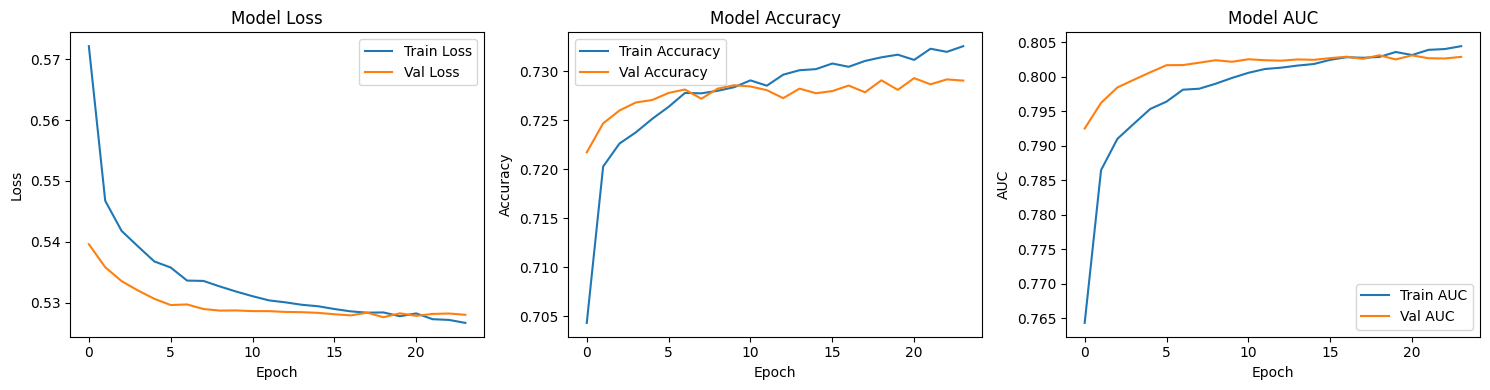

In [186]:
## Plot Training History
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# AUC
axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Val AUC')
axes[2].set_title('Model AUC')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()

plt.tight_layout()
plt.show()